In [1]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import tensorflow as tf
import keras_tuner as kt


#  Import and read the diabetes_data.csv.
import pandas as pd
diabetes_df = pd.read_csv('https://raw.githubusercontent.com/ComfyKoala/diabetes-classification/main/Maribel/diabetes_data_upload.csv')

In [3]:
#Dropping strongest features "Gender", "Polyuria", "Polydipsia"
diabetes_df=diabetes_df.drop(columns=["Gender", "Polyuria", "Polydipsia"])
diabetes_df.head()

,Age,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [4]:
#change all "yes" to 1 and all "no" to 0
diabetes_df = diabetes_df.replace({"Yes": 1, "No": 0})

#change "female" to 1 and "male" to 0
diabetes_df = diabetes_df.replace({"Female": 1, "Male": 0})

#change "Positive" to 1 and "Negative" to 0
diabetes_df = diabetes_df.replace({"Positive": 1, "Negative": 0})
diabetes_df.head()

,Age,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,0,1,1,1,1,1,1,1,1,1


In [5]:
# Split our preprocessed data into our features and target arrays
y = diabetes_df["class"].values
X = diabetes_df.drop(["class"], axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=10,
                                                    stratify=y)

In [6]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    # Allow kerastuner to decide the number of neurons in the first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=8,
        max_value=128,
        step=8), activation=activation, input_dim=13))

    # Allow kerastuner to decide the number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=8,
            max_value=128,
            step=8),
            activation=activation))

        # Optionally add dropout for regularization
        if hp.Choice('add_dropout_' + str(i), [True, False]):
            nn_model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_' + str(i),
                                                               min_value=0.0,
                                                               max_value=0.5,
                                                               step=0.1)))

    # Output layer
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    nn_model.compile(loss="binary_crossentropy",
                     optimizer=optimizer,
                     metrics=["accuracy"])

    return nn_model

In [7]:
# Import the kerastuner library
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Trial 60 Complete [00h 00m 07s]
val_accuracy: 0.6153846383094788

Best val_accuracy So Far: 0.8538461327552795
Total elapsed time: 00h 04m 13s


In [9]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 80,
 'num_layers': 1,
 'units_0': 32,
 'add_dropout_0': 0,
 'dropout_0': 0.0,
 'optimizer': 'rmsprop',
 'units_1': 80,
 'add_dropout_1': 1,
 'dropout_1': 0.4,
 'units_2': 120,
 'add_dropout_2': 1,
 'dropout_2': 0.0,
 'units_3': 32,
 'add_dropout_3': 1,
 'dropout_3': 0.30000000000000004,
 'units_4': 64,
 'add_dropout_4': 1,
 'dropout_4': 0.1,
 'units_5': 120,
 'add_dropout_5': 0,
 'dropout_5': 0.2,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0049'}

In [10]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

5/5 - 0s - 57ms/step - accuracy: 0.8538 - loss: 0.4334
Loss: 0.4333937168121338, Accuracy: 0.8538461327552795


In [11]:
best_hyper.values = {'activation': 'relu',
 'first_units': 32,
 'num_layers': 1,
 'units_0': 48,
 'add_dropout_0': 0,
 'dropout_0': 0.4,
 'optimizer': 'adam',
 'units_1': 32,
 'add_dropout_1': 0,
 'dropout_1': 0.4,
 'units_2': 112,
 'add_dropout_2': 0,
 'dropout_2': 0.4,
 'units_3': 80,
 'add_dropout_3': 0,
 'dropout_3': 0.0,
 'units_4': 96,
 'add_dropout_4': 1,
 'dropout_4': 0.0,
 'units_5': 128,
 'add_dropout_5': 0,
 'dropout_5': 0.0,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0038'}

In [12]:
# Define the model - deep neural net
n_features = X_train.shape[1]

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=best_hyper['first_units'], activation=best_hyper['activation'], input_dim=n_features))

# Add additional hidden layers based on num_layers
for i in range(best_hyper['num_layers']):
    nn.add(tf.keras.layers.Dense(units=best_hyper[f'units_{i}'], activation=best_hyper['activation']))

    # Add dropout if specified
    if best_hyper[f'add_dropout_{i}']:
        nn.add(tf.keras.layers.Dropout(rate=best_hyper[f'dropout_{i}']))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
nn.compile(optimizer=best_hyper['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])

# Check the structure of the model
nn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 32)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 48)                  │           1,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,081 (8.13 KB)

 Trainable params: 2,081 (8.13 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [14]:
# Create a callback that saves the model's weights every five epochs.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_weights_epoch_{epoch:02d}.weights.h5',
    save_weights_only=True,
    save_freq=5 * len(X_train)
)

# Train the model and pass the callback
fit_model = nn.fit(X_train, y_train, epochs=20, callbacks=[checkpoint_callback])

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4485 - loss: 2.0717
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5757 - loss: 0.7982 
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6141 - loss: 0.6591  
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4977 - loss: 0.7167  
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6330 - loss: 0.6578  
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6035 - loss: 0.6309  
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6538 - loss: 0.5981  
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6692 - loss: 0.5790  
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7117 - loss: 0.5895  
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7178 - loss: 0.5887 
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7766 - loss: 0.5680  
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc

In [15]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

5/5 - 0s - 33ms/step - accuracy: 0.7769 - loss: 0.4732
Loss: 0.4731619954109192, Accuracy: 0.7769230604171753


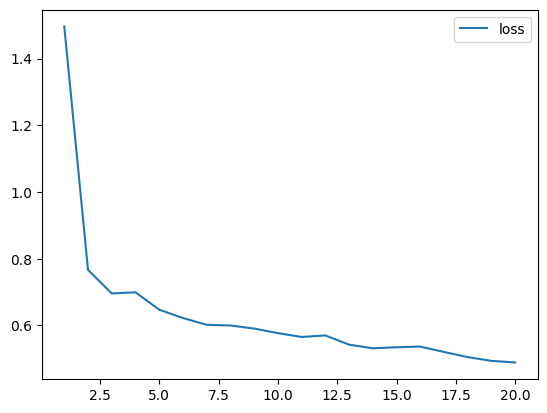

In [16]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

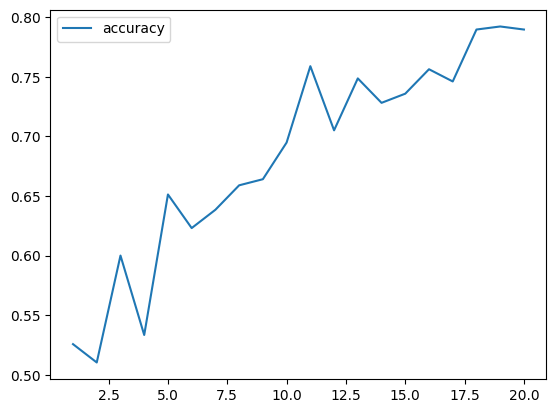

In [17]:
history_df.plot(y="accuracy")
plt.show()

### Accuracy 76.1%

In [18]:
#save model to a reusable variable
nn.save("diabetes_column_drop_model.h5")
